# Analisi Predittive su un Dataset di Campioni d'Acqua  

In questo notebook svilupperò delle **analisi predittive** su un **dataset** contenente una raccolta di **campioni d'acqua**.  
Ogni riga (**item**) del dataset rappresenta un campione, mentre le colonne (**features**) descrivono le sue **caratteristiche chimico-fisiche**, insieme a una feature che determina la sua **potabilità**.  

## Obiettivo  
L'obiettivo di questa analisi è creare un **modello predittivo** in grado di determinare, su un subset di dati mai visto in fase di addestramento, **se un campione d'acqua è potabile o meno** (**classificazione binaria**).  

## Fasi dell'analisi  

1. **Analisi Esplorativa dei Dati (EDA)**  
   - Studio delle **distribuzioni** delle variabili.  
   - Gestione di **outlier** e **valori nulli** (se presenti).  
   - Analisi delle **scale** delle feature.  
   - Selezione di un **subset ottimizzato** contenente solo le feature più rilevanti, determinate con il metodo del *chi2_contingency*.  
   - Le analisi verranno eseguite sia sul dataset completo che sul subset ottimizzato.  

2. **Scelta della metrica di classificazione**  
   - Dopo aver compreso le caratteristiche del dataset, verrà scelta una **metrica di valutazione** adatta all'obiettivo di previsione, che servirà per confrontare le performance dei modelli.  

3. **Selezione del modello**  
   - Verranno definiti dei **baseline model** da utilizzare come riferimento.  
   - Successivamente, si testeranno (*cross-validation*) **modelli più complessi** per determinare quali di essi raggiungono le migliori performance rispetto alla baseline.  

4. **Ottimizzazione degli iperparametri e training**  
   - Una volta scelti i modelli con le migliori prestazioni, si procederà con la **ricerca degli iperparametri ottimali** (*grid-search*) per migliorarne ulteriormente l'accuratezza predittiva.  

5. **Applicazione del modello**  
   - I modelli ottimizzati verranno applicati ai **test-set** e si effettuerà una verifica finale delle **prestazioni predittive**, valutando in quale dei due set il modello ha performato meglio.  

Per prima cosa importo il dataset ed estraggo le variabili *X* e *y*, successivamente divido il dataset in *training* e *test*.

In [1]:
# importazione delle librerie d'interesse
import pandas as pd
from sklearn.model_selection import train_test_split

seed = 35
# "importo" il dataset in una variabile e poi lo trasformo in un dataframe
file_path = r"Dataset/Copy of water_potability.csv"  
df = pd.read_csv(file_path)

# separo le features (X) dalla variabile target (y)
X = df.drop(columns=["Potability"])
y = df["Potability"]

# suddivido ulteriormente il mio dataset in training set(80%) e testing set(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# visualizzo le dimensioni dei set
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

Training set: (2620, 9), Testing set: (656, 9)


Questa prima operazione era per importare il nostro dataset e visualizzarne la forma in uno stato di suddivisione fra features e target. Tuttavia prima di poter operarare sull'insieme di dati, occorre analizzare diversi fattori.

Visualizzo l'aspetto generale del dataset:

In [2]:
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [3]:
# visualizzo i datatype delle colonne
df.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

Osservando gli output si denota che il dataset è composto da 10 features numeriche, 9 composte da *float64* (X) e una costituita da *int64* (y).

Visualizzo ora la presenza di valori mancanti nelle features

In [4]:
# Visualizziamo i valori nulli
print("Valori nulli per colonna:\n", df.isnull().sum())

Valori nulli per colonna:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


Considerando che le colonne *ph*, *Sulfate* e *Trihalomethanes* presentano molti valori nulli, sostituirli con la media o la mediana delle fetaures appiattirebbe la varianza delle features causando una perdita d'informazione. A questo proposito decido di usare un modello di regressione *RandomForest* per imputare i valori mancanti.

In [5]:
# importo la libreria del modello
from sklearn.ensemble import RandomForestRegressor
# inserisco in una lista le colonne che hanno valori nulli
columns_to_impute = ['ph', 'Sulfate', 'Trihalomethanes']
# per ogni colonna imposto le seguenti variabili
for col in columns_to_impute:
    df_train = df[df[col].notnull()]
    df_pred = df[df[col].isnull()]
    
    # Solo se ho dati sia per training che predizione:
    if len(df_train) > 0 and len(df_pred) > 0:
        # Uso tutte le altre colonne tranne quelle target per predire
        X_train = df_train.drop(columns=columns_to_impute)
        y_train = df_train[col]
        X_pred = df_pred.drop(columns=columns_to_impute)
        
        # Random Forest Model dentro il ciclo
        model = RandomForestRegressor(n_estimators=100, random_state=seed)
        model.fit(X_train, y_train)
        
        predicted_values = model.predict(X_pred)
        df.loc[df[col].isnull(), col] = predicted_values
        
        print(f"Imputati {len(predicted_values)} valori nella colonna '{col}'")
    else:
        print(f"Colonna '{col}' senza valori da imputare o dati insufficienti.")

Imputati 491 valori nella colonna 'ph'
Imputati 781 valori nella colonna 'Sulfate'
Imputati 162 valori nella colonna 'Trihalomethanes'


Verifico che non permangano valori nulli:

In [6]:
print(df.isnull().sum())

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


Proseguendo la mia analisi esplorativa decido di valutare la presenza di *outliers*.

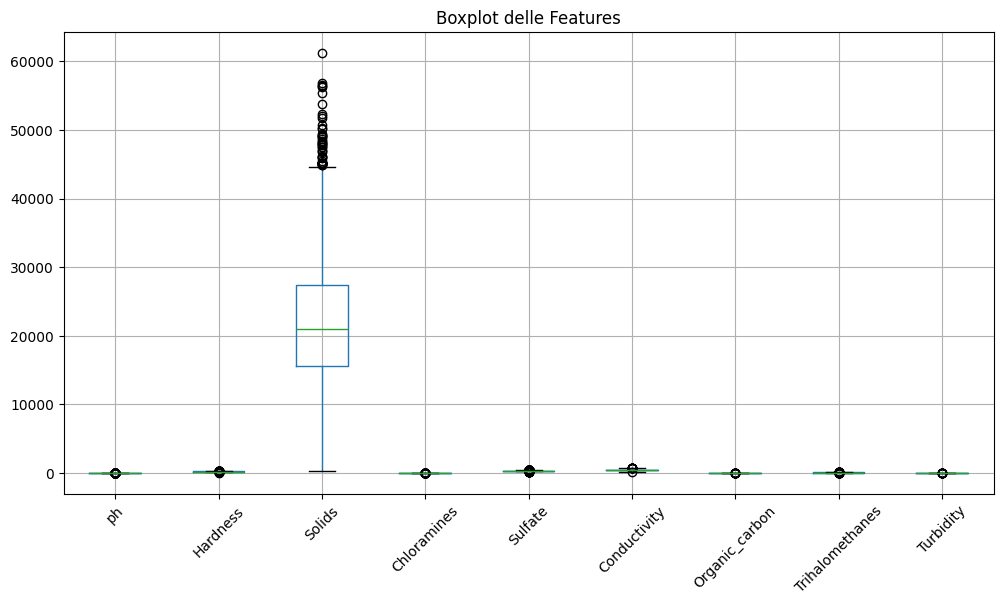

Numero di outlier per feature:
 ph                 111
Hardness            83
Solids              47
Chloramines         61
Sulfate            162
Conductivity        11
Organic_carbon      25
Trihalomethanes     54
Turbidity           19
dtype: int64

Numero di outlier usando Z-score:
 ph                 24
Hardness           18
Solids             20
Chloramines        20
Sulfate            29
Conductivity        7
Organic_carbon      4
Trihalomethanes    18
Turbidity           9
dtype: int64


In [7]:
# importazione delle librerie d'interesse
import numpy as np
import matplotlib.pyplot as plt
# defisco le nuove variabili aggiornate
X = df.drop(columns=["Potability"])
y = df["Potability"]

# creo la mia figura su cui si svilupperà il grafico
plt.figure(figsize=(12, 6))
# per rappresentare la distribuzione di X scelgo il boxplot
X.boxplot(rot=45)
plt.title("Boxplot delle Features")
plt.show()

# per rilevare gli outliers scelgo il metodo dei quartili, quindi inizio a impostare i confini di ognuno di essi
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# definisco gli outlier come valori al di fuori di (Q1 - 1.5*IQR, Q3 + 1.5*IQR)
# per poi contarli con il metodo sum()
outliers = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).sum()
# stampo i risultati
print("Numero di outlier per feature:\n", outliers)

# per completezza  utilizzo anche il Metodo Z-score per identificare outlier 
# (valori > 3 o < -3 sono considerati outlier)
from scipy.stats import zscore
# calcolo lo z-score per ogni valore di X
z_scores = np.abs(zscore(X))
# con una maschera booleana scelgo definisco gli outliers e li conteggio per colonna
outliers_z = (z_scores > 3).sum(axis=0)
# stampo i risultati
print("\nNumero di outlier usando Z-score:\n", outliers_z)

Una volta definiti e individuati gli *outliers* procedo a eliminarli.

In [8]:
# scelgo il metodo dei quartili in quanto è più robusto e ne ridefinisco i confini
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# creo la maschera per le righe senza outlier
mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)

# applico la maschera per rimuovere le righe corrispondenti sia in X che in y
X_cleaned = X[mask]
y_cleaned = y[mask]  

# stampo le dimensioni risultanti prima e dopo
print(f"Dimensione originale: X={X.shape}, y={y.shape}")
print(f"Dimensione dopo rimozione outlier: X={X_cleaned.shape}, y={y_cleaned.shape}")

Dimensione originale: X=(3276, 9), y=(3276,)
Dimensione dopo rimozione outlier: X=(2778, 9), y=(2778,)


Dal grafico a scatole emerge che la feature *Solids* ha un range dei valori estremamante più ampio rispetto alle altre features, ne deduco che sarà necessaria una scalatura, tuttavia per decidere il tipo di scalatura devo verificare la sua distribuzione

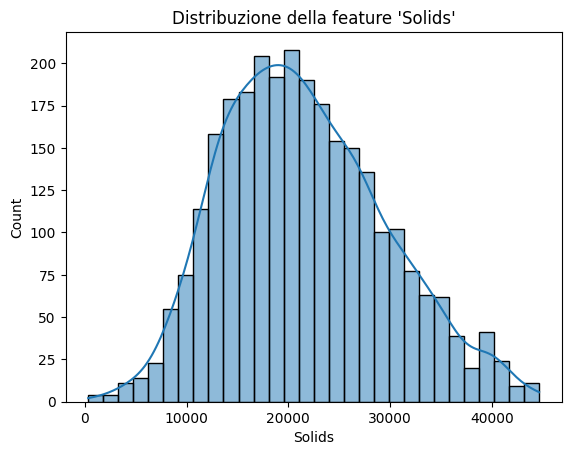

In [10]:
# importo le librerie d'interesse
import seaborn as sns
# sempre utilizzando la X aggiornata scelgo l'istogramma come grafico e ne visulizzo il risultato
sns.histplot(X_cleaned["Solids"], kde=True, bins=30)
plt.title("Distribuzione della feature 'Solids'")
plt.show()

Osservando il grafico deduco che la sua distribuzione appare piuttosto gaussiana, (a parte una lieve innalzamento verso 40000) quindi sarà possibile applicare lo *StandardScaler*

In [11]:
# Supponiamo che X_cleaned e y_cleaned siano già definiti
X = X_cleaned
y = y_cleaned
# importo la funzione di scalatura
from sklearn.preprocessing import StandardScaler
# la applico alla colonna d'interesse
scaler = StandardScaler()
X["Solids_scaled"] = scaler.fit_transform(X[["Solids"]])
# Rimuovo la colonna 'solids' da X
X = X.drop(columns=['Solids'])

Successivamente mi interessa visualizzare la distribuzione delle classi (target)

Potability
0    1739
1    1039
Name: count, dtype: int64


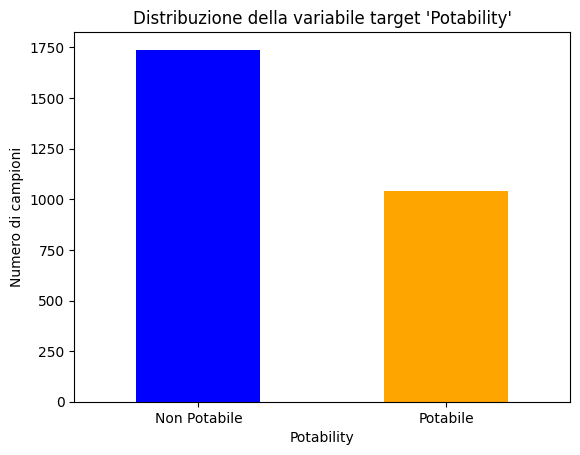

In [12]:
# creo una variabile che rappresenta il conteggio dei campioni divisi per classe
class_counts = y.value_counts()
# stampo il risultato
print(class_counts)

# visualizzo i conteggi con un semplice grafico a barre
class_counts.plot(kind="bar", color=["blue", "orange"])
plt.xticks(ticks=[0, 1], labels=["Non Potabile", "Potabile"], rotation=0)
plt.ylabel("Numero di campioni")
plt.title("Distribuzione della variabile target 'Potability'")
plt.show()

Per maggiore chiarezza ne visualizzo le percentuali:

In [13]:
percentuali = y.value_counts(normalize=True) * 100
print(percentuali)

Potability
0    62.598992
1    37.401008
Name: proportion, dtype: float64


Dai risultati ne emerge che le classi non sono bilanciate; se non si bilancia la distribuzione durante la fase di addestramento, il modello potrebbe imparare poco le caratteristiche della classe meno rappresentata. Per questo motivo ho scelto lo stratified sampling; ho ritenuto più idoneo questo metodo rispetto al random sampling, quest'ultimo infatti rischia di sottostimare o non selezionare nessun campione della classe meno "presente"

In [14]:
# divido X e y in training e test eseguendo l'opzione stratified che ne mantiene le proporzioni in entrambe le fasi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)

# verifico la distribuzione delle classi
print(y_train.value_counts(normalize=True))  # distribuzione delle classi nel training set
print(y_test.value_counts(normalize=True))   # distribuzione delle classi nel test set

Potability
0    0.626013
1    0.373987
Name: proportion, dtype: float64
Potability
0    0.625899
1    0.374101
Name: proportion, dtype: float64


In questa fase andrò a valutare un altro punto di cruciale importanza: verificare se esistono correlazioni fra le features. Per prima cosa svilupperò una matrice di correlazione

In [15]:
# calcolo la matrice di correlazione
corr_matrix = X_train.corr()

print(corr_matrix)

                       ph  Hardness  Chloramines   Sulfate  Conductivity  \
ph               1.000000  0.167565    -0.058108  0.002010      0.021085   
Hardness         0.167565  1.000000    -0.044153 -0.089604     -0.032448   
Chloramines     -0.058108 -0.044153     1.000000  0.038830     -0.021353   
Sulfate          0.002010 -0.089604     0.038830  1.000000      0.020330   
Conductivity     0.021085 -0.032448    -0.021353  0.020330      1.000000   
Organic_carbon   0.022223  0.007055    -0.005288  0.021681      0.018684   
Trihalomethanes  0.015681 -0.006179     0.022994 -0.011107      0.006306   
Turbidity       -0.057750 -0.022106     0.001261 -0.033628      0.011444   
Solids_scaled   -0.088421 -0.025926    -0.050083 -0.163781     -0.015660   

                 Organic_carbon  Trihalomethanes  Turbidity  Solids_scaled  
ph                     0.022223         0.015681  -0.057750      -0.088421  
Hardness               0.007055        -0.006179  -0.022106      -0.025926  
Chlorami

Per una maggiore visibilità ed interpretabilità traduco i risultati in una tabella *heatmap*

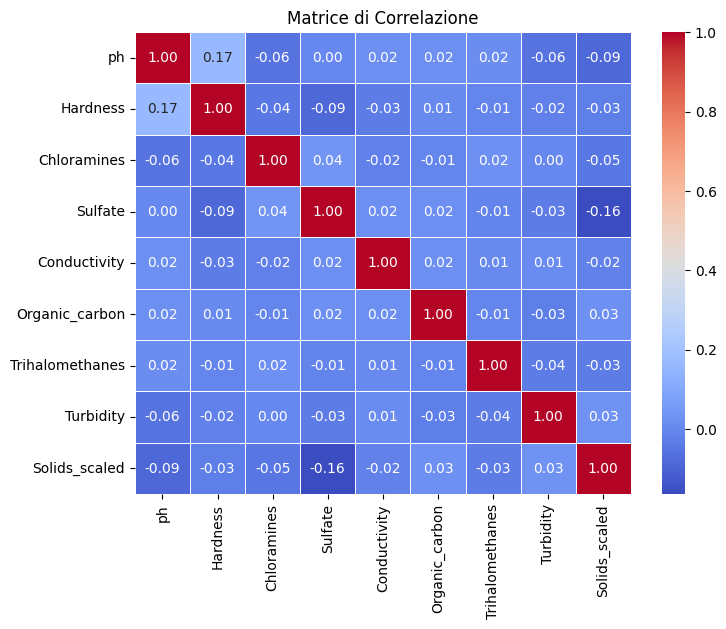

In [16]:
# creazione della heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice di Correlazione")
plt.show()

Dalla heatmap è possibile osservare che non esistono correlazioni (lineari) significative fra le varie features, allora mi pongo un'altra domanda: quali sono le features che sono fortemente correlate alle variabili target? Un sistema efficace che è in grado di dircelo è il **chi_squared test**; più nel dettaglio andremo a creare una tabella di contingenza in cui per ogni feature avremo due valori, il chi2 (più è alto più la feature è correlata alla variabile target) e il p-value (più è basso più la feature è correlata alla variabile target, dovrebbe essere minore di 0.05)

Prima di iniziare questi calcoli va tenuto conto di un dettaglio, il **chi_squared** funziona solo con features categoriali (composte da valori discreti), le nostre varibili indipendenti andranno dunque prima convertite in una scala di range categorici

In [17]:
# imposto una lista contenente il nome delle colonne che saranno convertite (esclusa la y)
columns_to_convert = ['ph', 'Hardness', 'Solids_scaled', 'Chloramines', 'Sulfate', 'Conductivity',
                      'Organic_carbon', 'Trihalomethanes', 'Turbidity']

# in un'altra lista inserisco il range di categorie discrete
labels = ['Molto Basso', 'Basso', 'Medio Basso', 'Medio', 'Medio Alto', 'Alto', 'Molto Alto']

# vado a creare una copia del dataset per la normalizzazione e categorizzazione
X_normalized = X_train.copy()

#per ogni colonna inizio un ciclo
for col in columns_to_convert:
    # calcolo dei percentili per definire i bins in modo adattivo (per ogni feature)
    quantiles = X_train[col].quantile([0, 0.15, 0.30, 0.50, 0.70, 0.85, 1.0]).values

    # aggiunta di un valore minimo per avere 8 bin edges
    bins = [float('-inf')] + list(quantiles)  # Ora ha 8 valori

    # applicazione della categorizzazione con pd.cut()
    X_normalized[col] = pd.cut(X_train[col], bins=bins, labels=labels, include_lowest=True)

# visualizzo le prime righe del dataset trasformato
X_normalized.head()

,ph,Hardness,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Solids_scaled
2522,Molto Alto,Molto Alto,Medio,Molto Alto,Medio,Medio Alto,Basso,Medio,Medio Alto
859,Medio,Medio Alto,Medio,Medio Alto,Medio Alto,Molto Alto,Medio Basso,Alto,Alto
669,Medio Alto,Medio,Alto,Molto Alto,Molto Alto,Medio Alto,Medio,Basso,Alto
830,Medio,Molto Alto,Molto Alto,Basso,Medio Alto,Medio,Medio,Alto,Medio
2394,Medio,Medio Basso,Alto,Alto,Molto Alto,Medio Alto,Medio,Medio Basso,Medio


In [18]:
# importo la funzione per il chi_squared test
from scipy.stats import chi2_contingency

# lista delle colonne categorizzate per cui avverranno i calcoli
categorical_features = ['ph', 'Hardness', 'Solids_scaled', 'Chloramines', 'Sulfate', 'Conductivity',
                        'Organic_carbon', 'Trihalomethanes', 'Turbidity']

# dizionario per salvare i risultati
chi2_results = {}

# eseguo il test Chi-quadro per ogni feature categorizzata rispetto a "Potability"
for feature in categorical_features:
    #creo la tabella di contingenza  per colonna in X
    contingency_table = pd.crosstab(X_normalized[feature], y_train)
    # calcolo i seguenti valori per la tabella prima creata
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    # creo un dizionario tenendo solo chi2 e p_value prima calcolati
    chi2_results[feature] = {'Chi2': chi2, 'p-value': p}

# converto i risultati in un DataFrame
chi2_df = pd.DataFrame.from_dict(chi2_results, orient='index')

# stampo i risultati
chi2_df

,Chi2,p-value
ph,18.948446,0.004252
Hardness,11.121399,0.084696
Solids_scaled,9.150462,0.165291
Chloramines,3.351554,0.763603
Sulfate,33.141926,0.000010
Conductivity,8.403900,0.209980
Organic_carbon,5.621462,0.466900
Trihalomethanes,1.895779,0.929030
Turbidity,2.825582,0.830398


Osservando i risultati posso giungere alle seguenti conclusioni: 
- le variabili *ph* e *Sulfate* sono significativamente correlate alla variabile target
- la variabile *Hardness* è moderatamente correlata (a y) per il suo p_value vicino allo 0.05 
- le altre variabili indipendenti presentano correlazioni deboli se non quasi nulle con le variabili y

La prossima fase è quella di scegliere la metrica corretta per valutare la bontà dei modelli, vediamo le caratteristiche di alcune metriche:
- **Accuracy**: valuta il numero di True Positive e True Negative correttamente identificati sul totale dei campioni; applicabile su dataset correttamente bilanciati
- **Precision**: valuta il numero di True Positive correttamente identificati sul totale dei campioni identificati come positivi, si applica quando i falsi positivi sono particolarmente dannosi ai fini dell'analisi
- **Recall**: valuta il numero di True Positive sul totale di True Positive e False Negative, utile quando è più costoso un caso di falso negativo 
- **Specificity**: valuta il numero di True Negative sul totale di True Negative e False Positive, utile quando si vuole principalmente evitare i falsi positivi
- **F1-score**: è la media armonica tra precision e recall, utile quando occorre bilanciare entrambi

In questo caso, per determinare la bontà dei modelli sarà scelta l'**F1-score**, più precisamente la **f1_macro**, in grado di dare un "peso uguale" ai risultati delle due classi.

In questa fase eseguirò uno **spot_check**, ovvero una sorta di screening per valutare le performance predittive di alcuni modelli di machine learning. Più nello specifico andrò ad applicare il metodo dello StratifiedKFold k-fold cross validation a due dataset: 
- il dataset di addestramento completo (*x_train*)
- il subset di *x_train* contenente le features che nella precedente analisi hanno dimostrato una maggiore correlazione alle variabili dipendenti

In [19]:
#importo le librerie con i relativi modelli
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
import numpy as np

# Imposto il seed per la riproducibilità
seed = 35

# Applico le funzioni ai dataset
X_subset_train = X_train[['ph', 'Sulfate']]  # Imputa solo il sottoinsieme

# Dizionario con i modelli aggiornati con class_weight='balanced'
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=seed, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=seed, class_weight='balanced'),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

# Definisco la cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Dizionario con i dataset
datasets = {
    "All Features": X_train,
    "Selected Features": X_subset_train
}

# Calcolo della baseline performance

# Modello random
random_model = DummyClassifier(strategy="uniform", random_state=seed)
random_scores = cross_val_score(random_model, X_train, y_train, cv=kf, scoring='f1_macro')
random_f1 = np.mean(random_scores)

# Modello majority class
majority_model = DummyClassifier(strategy="most_frequent")
majority_scores = cross_val_score(majority_model, X_train, y_train, cv=kf, scoring='f1_macro')
majority_f1 = np.mean(majority_scores)

print(f"Baseline Models:\nRandom Model F1-score: {random_f1:.4f}")
print(f"Majority Class Model F1-score: {majority_f1:.4f}")

# Esecuzione dello spot check con %timeit
for dataset_name, X in datasets.items():
    print(f"\nDataset: {dataset_name}")
    for model_name, model in models.items():
        print(f"\n{model_name}:")
        # Misuro il tempo di cross-validation
        get_ipython().run_line_magic('timeit', f"cross_val_score(model, X, y_train, cv=kf, scoring='f1_macro')")

        # Calcolo F1
        scores = cross_val_score(model, X, y_train, cv=kf, scoring='f1_macro')
        mean_f1 = np.mean(scores)
        print(f"Mean F1-score = {mean_f1:.4f}")

        # Confronto con le baseline
        if mean_f1 > random_f1 and mean_f1 > majority_f1:
            print(f"✅ {model_name} supera il modello random e il majority class model")
        elif mean_f1 > random_f1:
            print(f"⚠️ {model_name} supera il modello random, ma non il majority class model")
        else:
            print(f"❌ {model_name} NON supera il modello random")


Baseline Models:
Random Model F1-score: 0.4968
Majority Class Model F1-score: 0.3850

Dataset: All Features

Logistic Regression:
413 ms ± 7.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mean F1-score = 0.4893
❌ Logistic Regression NON supera il modello random

Random Forest:
3.13 s ± 35.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mean F1-score = 0.5598
✅ Random Forest supera il modello random e il majority class model

K-Nearest Neighbors:
150 ms ± 901 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mean F1-score = 0.5256
✅ K-Nearest Neighbors supera il modello random e il majority class model

Dataset: Selected Features

Logistic Regression:
48.3 ms ± 717 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Mean F1-score = 0.4924
❌ Logistic Regression NON supera il modello random

Random Forest:
1.68 s ± 6.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Mean F1-score = 0.5313
✅ Random Forest supera il modello random e il majority class model

A giudicare dai risultati ottenuti è possibile formulare le seguenti osservazioni:
- i due modelli che su entrambi i dataset hanno raggiunto i migliori risultati sono il **Random Forest** e il **K-Nearest Neighbors**
- in questa fase in termini assoluti il miglior modello si è rivelato il **Random Forest** nel dataset completo di addestramento
- la **Logistic Regression** non ha superato i baseline models in entrambi i dataset
- il **K-Nearest Neighbors** ha avuto prestazioni migliori nel subset

Successivamente, seleziono i due modelli più performanti per i dataset e ne valuto i migliori iperparametri

A questo proposito procedo nel seguente modo:
- per ogni modello seleziono alcuni dei suoi iperparametri più significativi
- per ogni iperparametro definisco una lista di valori, che rappresentano vari livelli di complessità e costo computazionale
- con la **grid_serach**, una volta definita la metrica di valutazione applico una cross validation per ogni iperparametro dei modelli
- sempre applicando questa analisi ai due dataset sarò in grado di valutare se aggiungere complessità ai modelli porterà a dei benefici in termini predittivi

In [20]:
# importo la funzione gridsearch
from sklearn.model_selection import GridSearchCV

# definisco in un dizionario gli iperparametri per RandomForestClassifier
rf_params = {
    'n_estimators': [50, 100, 200],  # numero di alberi
    'max_depth': [None, 10, 20],  # profondità dell'albero
    'min_samples_split': [2, 5, 10]  # minimo numero di campioni per dividere un nodo
}

# definisco gli iperparametri per KNeighborsClassifier
knn_params = {
    'n_neighbors': [3, 5, 7, 9],  # numero di vicini
    'weights': ['uniform', 'distance'],  # peso dei vicini
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

# creazione dei modelli
models = {
    "Random Forest": (RandomForestClassifier(random_state=seed), rf_params),
    "K-Nearest Neighbors": (KNeighborsClassifier(), knn_params)
}

# definizione della cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# dataset da testare
datasets = {
    "All Features": X_train,
    "Selected Features": X_subset_train
}

# esecuzione della Grid Search
for dataset_name, X in datasets.items():
    print(f"\n🔹 **Dataset: {dataset_name}**")
    for model_name, (model, params) in models.items():
        grid_search = GridSearchCV(model, param_grid=params, cv=kf, scoring='f1_macro', n_jobs=-1)
        grid_search.fit(X, y_train)
        print(f"\n📌 **{model_name}**")
        print(f"Migliori parametri: {grid_search.best_params_}")
        print(f"Miglior f1-score: {grid_search.best_score_:.4f}")



🔹 **Dataset: All Features**

📌 **Random Forest**
Migliori parametri: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Miglior f1-score: 0.5874

📌 **K-Nearest Neighbors**
Migliori parametri: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Miglior f1-score: 0.5332

🔹 **Dataset: Selected Features**

📌 **Random Forest**
Migliori parametri: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Miglior f1-score: 0.5508

📌 **K-Nearest Neighbors**
Migliori parametri: {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
Miglior f1-score: 0.5535


Una volta ottenuti i migliori iperparametri per ogni modello applico i modelli "migliorati" alla porzione di *test set*

In [21]:
# importo la metrica di valutazione
from sklearn.metrics import f1_score

# creazione dei migliori modelli con i parametri ottimizzati
best_rf_full = RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=100, random_state=seed)
best_KNN_full = KNeighborsClassifier(n_neighbors=5, p=2, weights='distance')
best_rf_subset = RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200, random_state=seed)
best_KNN_subset = KNeighborsClassifier(n_neighbors=7, p=2, weights='uniform')

# Addestramento sui rispettivi dataset di training
best_rf_full.fit(X_train, y_train)
best_KNN_full.fit(X_train, y_train)
best_rf_subset.fit(X_subset_train, y_train)
best_KNN_subset.fit(X_subset_train, y_train)

# Predizione sui dati di test
y_pred_rf_full = best_rf_full.predict(X_test)
y_pred_KNN_full = best_KNN_full.predict(X_test)
y_pred_rf_subset = best_rf_subset.predict(X_test[["ph", "Sulfate"]])
y_pred_KNN_subset = best_KNN_subset.predict(X_test[["ph", "Sulfate"]])

# Calcolo del f1_macro per ogni modello
f1_rf_full = f1_score(y_test, y_pred_rf_full, average='macro')
f1_knn_full = f1_score(y_test, y_pred_KNN_full, average='macro')
f1_rf_subset = f1_score(y_test, y_pred_rf_subset, average='macro')
f1_knn_subset = f1_score(y_test, y_pred_KNN_subset, average='macro')

# Stampa dei risultati
print(f"📌 Random Forest (Full Dataset) → F1 Macro: {f1_rf_full:.4f}")
print(f"📌 KNeighborsClassifier (Full Dataset) → F1 Macro: {f1_knn_full:.4f}")
print(f"📌 Random Forest (Subset: ph, Sulfate) → F1 Macro: {f1_rf_subset:.4f}")
print(f"📌 KNeighborsClassifier (Subset: ph, Sulfate) → F1 Macro: {f1_knn_subset:.4f}")

📌 Random Forest (Full Dataset) → F1 Macro: 0.6034
📌 KNeighborsClassifier (Full Dataset) → F1 Macro: 0.5194
📌 Random Forest (Subset: ph, Sulfate) → F1 Macro: 0.4844
📌 KNeighborsClassifier (Subset: ph, Sulfate) → F1 Macro: 0.4839


Dai punteggi ottenuti si evince che il miglior modello predittivo è il **Random Forest**, ottenuto sul dataset con tutte le features. Questo risultato ci suggerisce che in alcuni casi, mantenere solo le features più rilevanti per evitare di "catturare" anche il caos non sempre porta a prestazioni di generalizzazione migliori.

*Grazie per l'attenzione!!*